In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.ndimage import gaussian_filter1d
import json
from scipy.special import expit
from scipy import signal
from scipy.optimize import curve_fit
import re
from more_itertools import windowed
from scipy.signal import find_peaks, correlate

### Notes:

 - remove all instances of swimming from eye data to recognise eye events
 - cross correlate left right traces
 - detecting negative contrast (OFF pathway) and swimming bouts in OMR
 - methionine preferentially adjusts gain through OFF pathway 



### Neccessary Functions

In [2]:
def load_json_data(path):
    # Opening JSON file
    f = open(path)

    # returns JSON object as a dictionary
    data = json.load(f)
    df = pd.json_normalize(data)

    final_list_of_fish_dicts = []
    for i, r in df.iterrows():
        fish_dict = {}
        for stim_type in df.columns:
            fish_dict[stim_type] = []
            for counter in range(len(df[stim_type][0])-1):
                dfdf = df[stim_type][i][counter]
                dfdfdf = json.loads(dfdf)
                norm_df = pd.json_normalize(dfdfdf, max_level=0)
                empty_np = np.zeros((200, ))
                for col in norm_df.columns:
                    col_array = np.array([pd.json_normalize(norm_df[col])][0])[0]
                    if col_array.shape == (199, ):
                        col_array = np.insert(col_array, 0, 0)
                    empty_np = np.vstack((empty_np, col_array))
                final_df = pd.DataFrame(empty_np)
                final_df = final_df.transpose().drop(columns=[0])
                final_df.columns = norm_df.columns
                fish_dict[stim_type].append(final_df)
        final_list_of_fish_dicts.append(fish_dict)

    return final_list_of_fish_dicts

def gauss(X,C,X_mean,sigma):
    return C*np.exp(-(X-X_mean)**2/(2*sigma**2))   

def calculate_eye_vergence_threshold(data):
    
    left = data['L_EYE'].fillna(method='ffill')
    right = data['R_EYE'].fillna(method='ffill')    
    combined = np.concatenate([right,-left])
    
    hist, bin_edges = np.histogram(combined)
    hist=hist/sum(hist)

    n = len(hist)
    x_hist=np.zeros((n),dtype=float) 
    for ii in range(n):
        x_hist[ii]=(bin_edges[ii+1]+bin_edges[ii])/2

    y_hist=hist
    mean = sum(x_hist*y_hist)/sum(y_hist)                  
    sigma = sum(y_hist*(x_hist-mean)**2)/sum(y_hist) 

    #Gaussian least-square fitting process
    param_optimised,param_covariance_matrix = curve_fit(gauss,x_hist,y_hist,method='dogbox',\
                                                        p0=[max(y_hist),mean,sigma],maxfev=5000)
    x_hist_2=np.linspace(np.min(x_hist),np.max(x_hist),500)
    weights = np.ones_like(combined) / len(combined)
    
    ### Calculate full width at half maximum --> Threshold for event detector
    fwhm = 2*np.sqrt(2*np.log(2))*sigma 
    
    return fwhm/2

### Loading Data

In [7]:
list_of_fish_dicts = load_json_data('../json_data/STIM_5_6_SIZEDOT_0.004_0.025.json')

In [8]:
len(list_of_fish_dicts)

50

In [5]:
for fish in [0,'01','02','03','04','05','06','07','08','09',10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,\
             27,28,29,30,31,32,33,34,35,36,37,38,39,40]:
    exec(f'data{fish} = pd.read_csv("../raw_data/STIM_5_6_SIZEDOT_0.004_0.025/zfdata{fish}.csv")')

### Filtering out Noisy Eye Angle Data 

In [ ]:
np.array(data0['R_EYE'])[-1]

In [ ]:
eye_data = fish0['STIM_type_6.SIZE_dot_0.004'][5]['L_EYE']
for index,data in enumerate(eye_data):
    print(index,data)

In [ ]:
find_peaks(eye_data, prominence=(0.05))[0]

In [13]:
fish0 = list_of_fish_dicts[0]
fish0['STIM_type_6.SIZE_dot_0.004'][5]['L_EYE']

0     -0.373218
1     -0.380159
2     -0.369189
3     -0.395860
4     -0.376056
         ...   
195   -0.322619
196   -0.318199
197   -0.315654
198   -0.317183
199   -0.318106
Name: L_EYE, Length: 200, dtype: float64

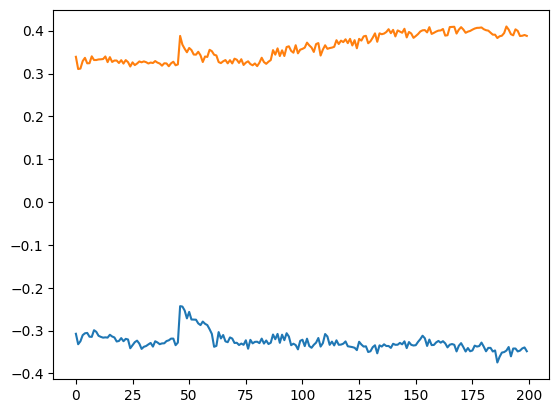

In [95]:
x = fish0['STIM_type_6.SIZE_dot_0.004'][5]
# peaks, _ = find_peaks(x, prominence=(0.06))
# np.diff(peaks)
plt.plot(x['L_EYE'])
plt.plot(x['R_EYE'])
# plt.plot(peaks, x[peaks], "x")
plt.show()

In [ ]:
peaks

In [ ]:
for window in list(windowed(data0['R_EYE'], 5, fillvalue=np.array(data0['R_EYE'])[-1],step=2)):
    if window[2] 

### Making Threshold List

In [ ]:
threshold_list = [calculate_eye_vergence_threshold(df) for df in [data0,data01,data02,data03,data04,data05,data06,\
                                                                  data07,data08,data09,data10,data11,data12,data13,\
                                                                  data14,data15,data16,data17,data18,data19,data20,\
                                                                  data21,data22,data23,data24,data25,data26,data27,\
                                                                  data28,data29,data30,data31,data32,data33,data34,\
                                                                  data35,data36,data37,data38,data39,data40]]

### Plotting Gaussian Fit with Histogram

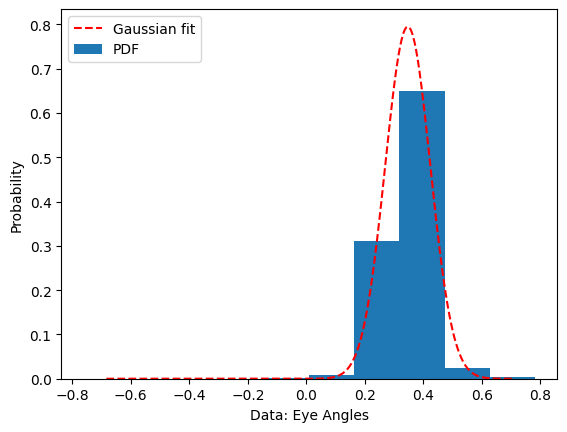

In [15]:
data = data0
left = data['L_EYE'].fillna(method='ffill')
right = data['R_EYE'].fillna(method='ffill')   
x_data = np.concatenate([right,-left])

#plotting the histogram
hist, bin_edges = np.histogram(x_data)
hist=hist/sum(hist)

n = len(hist)
x_hist=np.zeros((n),dtype=float) 
for ii in range(n):
    x_hist[ii]=(bin_edges[ii+1]+bin_edges[ii])/2
    
y_hist=hist

mean = sum(x_hist*y_hist)/sum(y_hist)                  
sigma = sum(y_hist*(x_hist-mean)**2)/sum(y_hist) 

#Gaussian least-square fitting process
param_optimised,param_covariance_matrix = curve_fit(gauss,x_hist,y_hist,method='dogbox',\
                                                    p0=[max(y_hist),mean,sigma],maxfev=5000)
fig = plt.figure()
x_hist_2=np.linspace(np.min(x_hist),np.max(x_hist),500)
plt.plot(x_hist_2,gauss(x_hist_2,*param_optimised),'r--',label='Gaussian fit')

#Normalise the histogram values
weights = np.ones_like(x_data) / len(x_data)
plt.hist(x_data, weights=weights,label='PDF')

#setting the label,title and grid of the plot
plt.xlabel("Data: Eye Angles")
plt.ylabel("Probability")
plt.legend()
plt.show()

### Testing Threshold Calculator 

In [ ]:
fish0['STIM_type_6.SIZE_dot_0.004'][5]

In [11]:
# test_frame = fish0['STIM_type_6.SIZE_dot_0.004'][5]
# threshold = calculate_eye_vergence_threshold(data0)

# left_eye_derivative = np.gradient(gaussian_filter1d(test_frame['L_EYE'],2))
# left_eye_derivative_zeroed = []
# for frame in left_eye_derivative:
#     if frame<=threshold:
#         frame=0
#     left_eye_derivative_zeroed.append(frame)
# # plt.plot(test_frame['L_EYE'])
# plt.plot(left_eye_derivative)
# # plt.plot(left_eye_derivative_zeroed)

# right_eye_derivative = np.abs(np.gradient(gaussian_filter1d(test_frame['R_EYE'],2)))
# right_eye_derivative_zeroed = []
# for frame in right_eye_derivative:
#     if frame<=threshold:
#         frame=0
#     right_eye_derivative_zeroed.append(frame)
# # plt.plot(test_frame['R_EYE'])
# plt.plot(right_eye_derivative)
# # plt.plot(right_eye_derivative_zeroed)
# # plt.axhline(threshold,color='r')
# # plt.xlim(120,130)
# plt.show()

In [ ]:
df_ = pd.DataFrame(columns=['L_EYE','R_EYE'])
df_['L_EYE'] = test_frame['L_EYE']
df_['R_EYE'] = test_frame['R_EYE']

In [71]:
fish0 = list_of_fish_dicts[1]
fish0_stim5_dot0004 = fish0['STIM_type_6.SIZE_dot_0.004']
test_frame = fish0_stim5_dot0004[5]

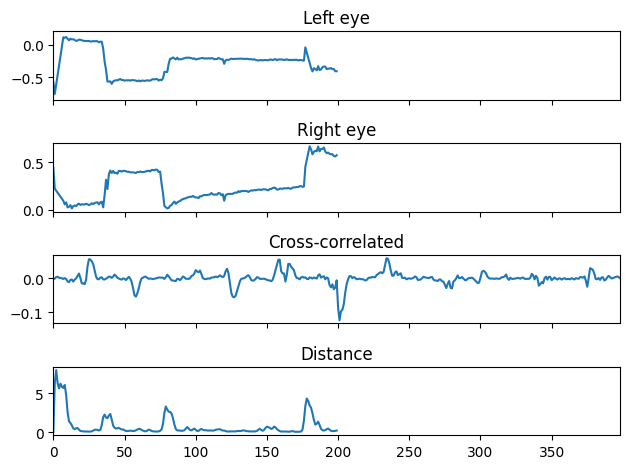

In [82]:
test_frame = fish0['STIM_type_6.SIZE_dot_0.004'][1]
corr = correlate(np.gradient(test_frame['L_EYE']), np.gradient(test_frame['R_EYE']),method='fft')
# corr = signal.correlate(test_frame['L_EYE'], test_frame['R_EYE'], mode='same') / 200
clock = np.arange(100, len(test_frame['L_EYE']), 200)
fig, (ax_orig, ax_noise, ax_corr, ax_tail) = plt.subplots(4, 1, sharex=True)
ax_orig.plot(test_frame['L_EYE'])
# ax_orig.plot(clock, test_frame['L_EYE'][clock], 'ro')
ax_orig.set_title('Left eye')
ax_noise.plot(test_frame['R_EYE'])
ax_noise.set_title('Right eye')
ax_corr.plot(corr)
ax_tail.plot(test_frame['Distance_pts'])
ax_tail.set_title('Distance')
# ax_corr.plot(clock, corr[clock], 'ro')
# ax_corr.axhline(0.5, ls=':')
ax_corr.set_title('Cross-correlated')
ax_orig.margins(0, 0.1)
fig.tight_layout()
plt.show()

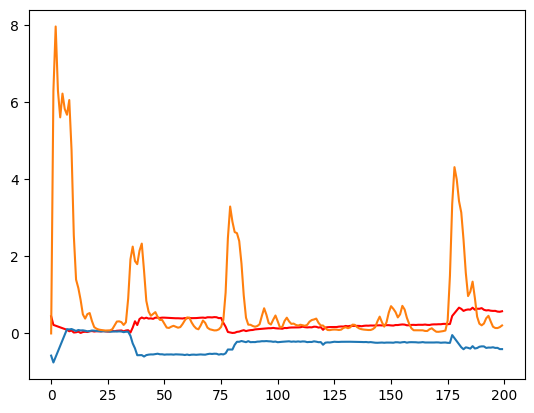

In [94]:
plt.plot(test_frame['R_EYE'],'r')
plt.plot(test_frame['L_EYE'])
plt.plot(test_frame['Distance_pts'])
# plt.ylim(-1,2);

0.5 sec sliding window for eye vergence detection

In [ ]:
left_converge = fish0['STIM_type_5.SIZE_dot_0.004'][12]['L_EYE']
right_converge = fish0['STIM_type_5.SIZE_dot_0.004'][12]['R_EYE']

left_nonconverge = fish0['STIM_type_5.SIZE_dot_0.004'][7]['L_EYE']
right_nonconverge = fish0['STIM_type_5.SIZE_dot_0.004'][7]['R_EYE']

In [ ]:
left_converge.to_csv('../raw_data/left_converge.csv')

In [ ]:
right_converge.to_csv('../raw_data/right_converge.csv')
left_nonconverge.to_csv('../raw_data/left_nonconverge.csv')
right_nonconverge.to_csv('../raw_data/right_nonconverge.csv')

In [ ]:
test_frame = fish0['STIM_type_5.SIZE_dot_0.004'][7]
corr = periodic_corr(np.gradient(test_frame['L_EYE']), np.gradient(test_frame['R_EYE']))
# corr = signal.correlate(test_frame['L_EYE'], test_frame['R_EYE'], mode='same') / 200
clock = np.arange(100, len(test_frame['L_EYE']), 200)
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(test_frame['L_EYE'])
# ax_orig.plot(clock, test_frame['L_EYE'][clock], 'ro')
ax_orig.set_title('Left eye')
ax_noise.plot(test_frame['R_EYE'])
ax_noise.set_title('Right eye')
ax_corr.plot(corr)
# ax_corr.plot(clock, corr[clock], 'ro')
# ax_corr.axhline(0.5, ls=':')
ax_corr.set_title('Cross-correlated')
ax_orig.margins(0, 0.1)
fig.tight_layout()
plt.show()

In [ ]:
len(corr)

In [ ]:
px.line(corr)

In [ ]:
threshold

### Event Table Function - Displacement Events

In [79]:
def make_event_table(dataframe): 
    eye_angles = dataframe['Distance_pts']
    if np.sum(np.isnan(eye_angles)) > 0:
        np.nan_to_num(eye_angles,copy=False,nan=0)
    t = np.arange(0, 200, 1)
    sig = eye_angles #composite signal
    sig_clean = sig #copy for later comparison
    minsignal, maxsignal = sig.min(), sig.max()
    widths = np.arange(1, 200)
    cwtmatr = signal.cwt(sig, signal.ricker, widths)
    t = np.arange(0, 200, 1)
    cwt_sig = cwtmatr[5,:] #composite signal
    signal_clean = sig #copy for later comparison
    minsignal, maxsignal = cwt_sig.min(), cwt_sig.max()
    
    ## Compute Fourier Transform
    n = len(t)
    fhat = np.fft.fft(cwt_sig, n) #computes the fft
    psd = fhat * np.conj(fhat)/n
    freq = (1/(1*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index
    
    ## Filter out noise
    threshold = 2
    psd_idxs = psd > threshold #array of 0 and 1
    psd_clean = psd * psd_idxs #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal
    signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform
    fft_signal = signal_filtered.real
    fft_gauss = gaussian_filter1d(fft_signal,sigma=5)
    eye_angles_2 = []
    for frame in fft_gauss:
        if frame<=1.5:
            frame=0
        eye_angles_2.append(frame)
    fft_gauss = eye_angles_2
    
    # Fiter out events mid-beginning and mid-end 
    if fft_gauss[0] != 0:
        zero_start = fft_gauss.index(0)
        fft_gauss[:zero_start] = [0]*(zero_start)
    if fft_gauss[-1] != 0:
        end_zero = -(fft_gauss[::-1].index(0))
        fft_gauss[end_zero:] = [0]*(-end_zero) 
    

    indices = []
    for val in fft_gauss:
        if val == 0:
            indices.append(0)
        else:
            indices.append(fft_gauss.index(val))


    df = pd.DataFrame(fft_gauss,columns=['fft_gauss'])
    df['ind'] = indices
    df['init_cum'] = dataframe['CUM_angle']
    df['init_dist'] = dataframe['Distance_pts']
    df['event'] = 0


    counter = 1 
    for index, row in df.iterrows():  
        if row['fft_gauss'] != 0:
            df.at[index,'event'] = counter
            if df.at[index+1,'fft_gauss'] == 0:
                counter += 1


    event_df = pd.DataFrame(columns=['event','duration_s','delta_theta_rad','distance','start_ind','end_ind','latency_s'])
    event_df['event'] = df['event'].unique()[1:]

    event_df['duration_s'] = [((df['event']==event).sum())/100 for event in (df['event']).unique()[1:]]

    event_df['start_ind'] = [int(df[df['event']==event].reset_index().iloc[0][0]) for event in (df['event']).unique()[1:]]
    event_df['end_ind'] = [int(df[df['event']==event].reset_index().iloc[-1][0]) for event in (df['event']).unique()[1:]]

    event_df['delta_theta_rad'] = [df['init_cum'][r['end_ind']]-df['init_cum'][r['start_ind']] \
                                   for i, r in event_df.iterrows()]

    event_df['latency_s'] = [None if i-1 == -1 else (event_df['start_ind'][i]-event_df['end_ind'][i-1])/100 \
                             for i, r in event_df.iterrows()]

    # event_df['distance'] = ADD all frames per event except first one
    event_df['distance'] = [df[df['event']==ev]['init_dist'].sum() - df[df['event']==ev]['init_dist'].reset_index()\
                            ['init_dist'][0] for ev in df['event'].unique()[1:]]

#     event_df = event_df.drop(columns=['start_ind','end_ind'])
    
    return event_df

In [23]:
# df_names = ['am_e_1','am_e_10','am_e_20','am_e_30','am_e_50','am_e_70','am_e_100','pm_e_1','pm_e_10','pm_e_20',\
#          'pm_e_30','pm_e_50','pm_e_70','pm_e_100','am_me_1','am_me_10','am_me_20','am_me_30','am_me_50','am_me_70',\
#          'am_me_100','pm_me_1','pm_me_10','pm_me_20','pm_me_30','pm_me_50','pm_me_70','pm_me_100']

# dataframes = [am_eC1,am_eC10,am_eC20,am_eC30,am_eC50,am_eC70,am_eC100,pm_eC1,pm_eC10,pm_eC20,pm_eC30,pm_eC50,pm_eC70,\
#              pm_eC100,am_meC1,am_meC10,am_meC20,am_meC30,am_meC50,am_meC70,am_meC100,pm_meC1,pm_meC10,pm_meC20,\
#              pm_meC30,pm_meC50,pm_meC70,pm_meC100]



# full_event_table = pd.DataFrame(columns=['event_n','fish_n','event','duration_s','delta_theta_rad','distance',\
#                                          'latency_s','time','medium','contrast'])

# fish_counter = 1
# for name,df in zip(df_names,dataframes):
#     for fish in df:
#         event_df = make_event_table(fish)
#         event_df['time'] = name.split('_')[0]
#         event_df['medium'] = name.split('_')[1]
#         event_df['contrast'] = int(name.split('_')[2])
#         event_df['event_n'] = 0
#         event_df['fish_n'] = fish_counter
#         fish_counter += 1
#         full_event_table = pd.concat([full_event_table,event_df])
        
# full_event_table['event_n'] = np.arange(1,len(full_event_table)+1,1)
# full_event_table = full_event_table.set_index('event_n')

# full_event_table

In [80]:
events = make_event_table(fish0['STIM_type_6.SIZE_dot_0.004'][1])

In [81]:
events

,event,duration_s,delta_theta_rad,distance,start_ind,end_ind,latency_s
0,1,0.07,0.034967,10.617135,36,42,NaN
1,2,0.09,0.573521,19.084620,77,85,0.35
2,3,0.11,-0.577177,25.620890,176,186,0.91


/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_98278/499930766.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(sig,'k',lw=1,color='k')


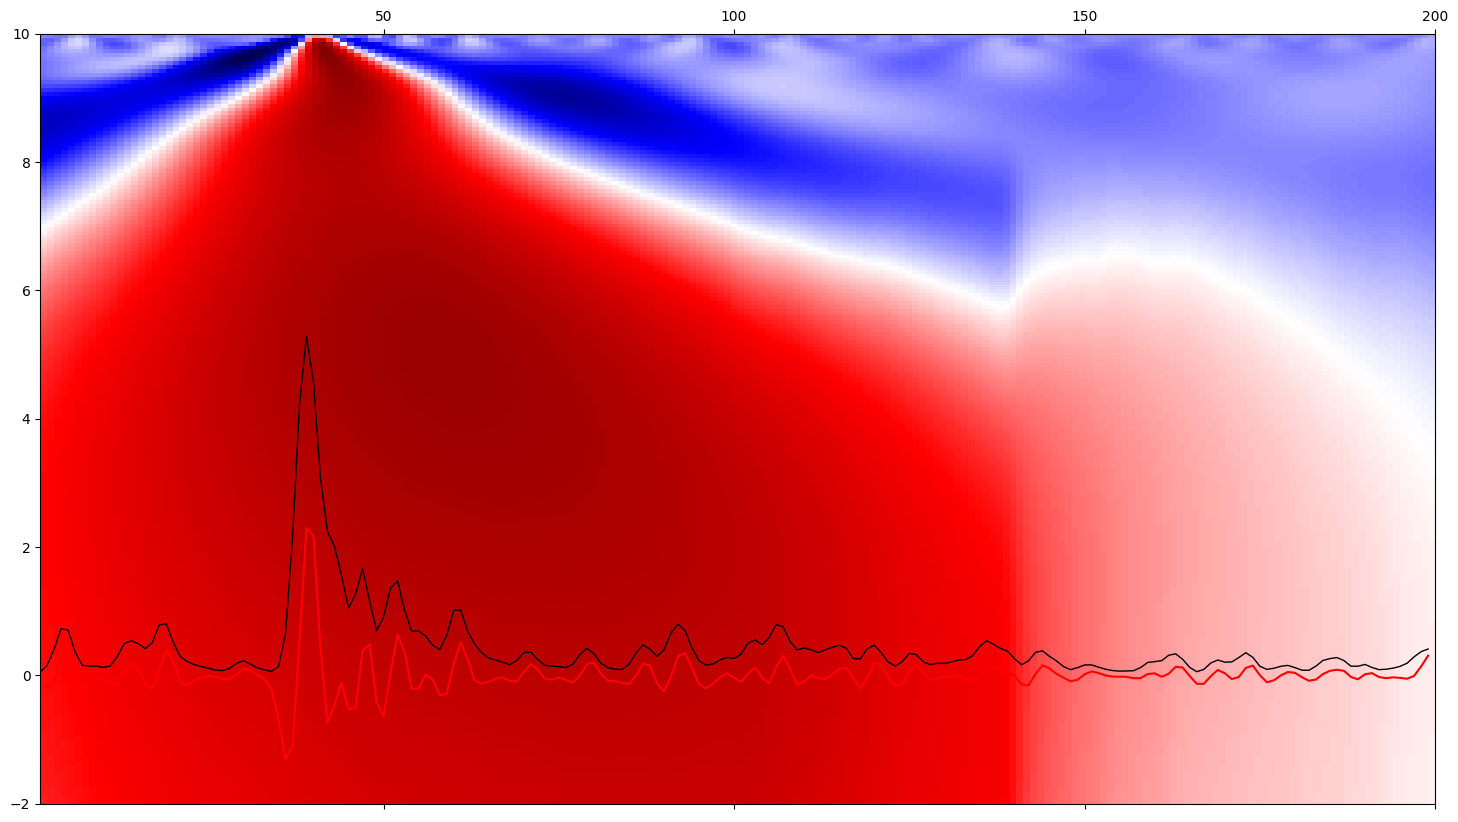

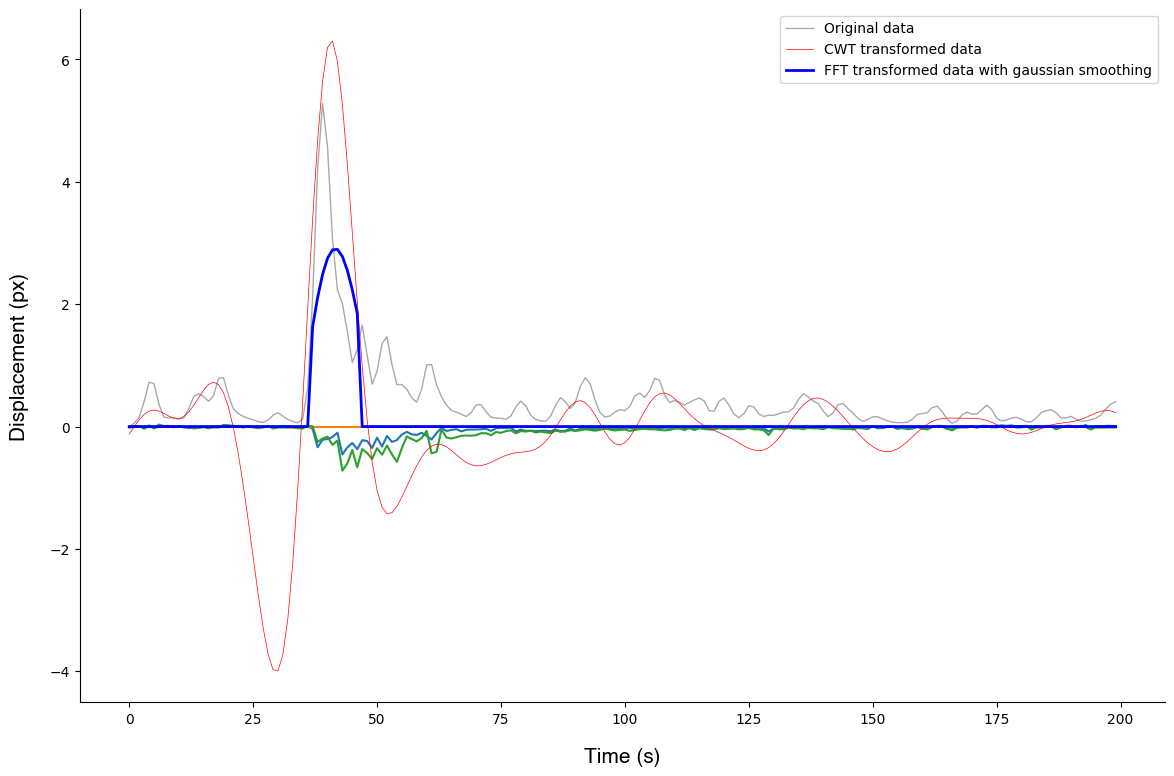

In [26]:
test_frame = fish0['STIM_type_6.SIZE_dot_0.004'][5]
fish_distance = test_frame['Distance_pts']
if np.sum(np.isnan(fish_distance)) > 0:
    np.nan_to_num(fish_distance,copy=False,nan=0)

t = np.arange(0, 200, 1)
sig = fish_distance #composite signal
sig_clean = sig #copy for later comparison
minsignal, maxsignal = sig.min(), sig.max()

widths = np.arange(1, 200)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
fig, ax = plt.subplots(1,1,figsize=(18,10))
ax.plot(cwtmatr[0,:],color='r')
ax.plot(sig,'k',lw=1,color='k')
ax.matshow(cwtmatr.real, extent=[1, 200, -2, 10], cmap='seismic', aspect='auto',interpolation='nearest')
plt.show()

t = np.arange(0, 200, 1)
cwt_sig = cwtmatr[5,:] #composite signal
signal_clean = sig #copy for later comparison
minsignal, maxsignal = cwt_sig.min(), cwt_sig.max()

## Compute Fourier Transform
n = len(t)
fhat = np.fft.fft(cwt_sig, n) #computes the fft
psd = fhat * np.conj(fhat)/n
freq = (1/(1*n)) * np.arange(n) #frequency array
idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index

## Filter out noise
threshold = 2
psd_idxs = psd > threshold #array of 0 and 1
psd_clean = psd * psd_idxs #zero out all the unnecessary powers
fhat_clean = psd_idxs * fhat #used to retrieve the signal

signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform

fft_signal = signal_filtered.real
fft_gauss = gaussian_filter1d(fft_signal,sigma=5)

fish_distance_2 = []
for frame in fft_gauss:
    if frame<=1.5:
        frame=0
    fish_distance_2.append(frame)
fft_gauss = fish_distance_2

fig, ax = plt.subplots(1,1,figsize=(14,9))
ax.plot(sig,'darkgray',lw=1,label='Original data')
ax.plot(test_frame['MCURVE_tail'])
ax.plot(test_frame['TAIL_P1'])
ax.plot(test_frame['TAIL_P6'])
ax.plot(cwt_sig, 'red', lw=0.5, label='CWT transformed data')
ax.plot(fft_gauss, '-', color='b',lw=2,label='FFT transformed data with gaussian smoothing')
# ax.axhline(y=1, color='r', linestyle='-',lw=0.5,label='threshold line')
ax.legend()
# ax.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# x_ticks = [0, 500, 1000, 1500, 2000, 2500, 3000]
# x_labels = [0,5,10,15,20,25,30] 
# plt.xticks(x_ticks, x_labels,fontsize=13)
# plt.yticks(fontsize=13)
plt.xlabel('Time (s)',size=15,name='Helvetica',labelpad=15)
plt.ylabel('Displacement (px)',size=15,name='Helvetica',labelpad=15)
plt.show()

### Regex Extraction of Stimulus Type and Variable Parameters

In [ ]:
stim_type = int(re.findall('\d',re.findall('e_\d','STIM_type_0.SIZE_dot_0.0')[0])[0])

In [ ]:
fish0 = list_of_fish_dicts[0]

In [ ]:
fish0_stim5_dot025 = fish0['STIM_type_6.SIZE_dot_0.0']

In [ ]:
len(fish0_stim5_dot025)

In [ ]:
needed_dict_keys = ['STIM_type_0.SIZE_dot_0.0',\
             'STIM_type_5.SIZE_dot_0.004','STIM_type_5.SIZE_dot_0.025',\
             'STIM_type_6.SIZE_dot_0.004','STIM_type_6.SIZE_dot_0.025']

### Vergence Event Table Columns 

- Event number
- Fish number
- Start index
- End index
- Change in left eye angle
- Change in right eye angle
- Event latency 
- Distance 
- Stimulus Type
- Size of dot stimulus
- Amplitude of stimulus angle 

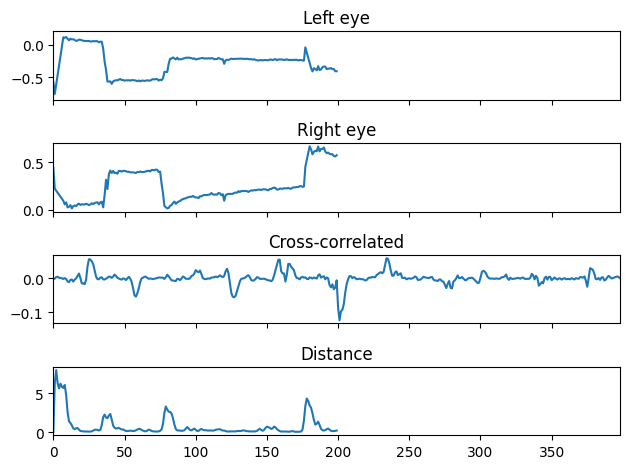

In [96]:
test_frame = fish0['STIM_type_6.SIZE_dot_0.004'][1]
corr = correlate(np.gradient(test_frame['L_EYE']), np.gradient(test_frame['R_EYE']),method='fft')
# corr = signal.correlate(test_frame['L_EYE'], test_frame['R_EYE'], mode='same') / 200
clock = np.arange(100, len(test_frame['L_EYE']), 200)
fig, (ax_orig, ax_noise, ax_corr, ax_tail) = plt.subplots(4, 1, sharex=True)
ax_orig.plot(test_frame['L_EYE'])
# ax_orig.plot(clock, test_frame['L_EYE'][clock], 'ro')
ax_orig.set_title('Left eye')
ax_noise.plot(test_frame['R_EYE'])
ax_noise.set_title('Right eye')
ax_corr.plot(corr)
ax_tail.plot(test_frame['Distance_pts'])
ax_tail.set_title('Distance')
# ax_corr.plot(clock, corr[clock], 'ro')
# ax_corr.axhline(0.5, ls=':')
ax_corr.set_title('Cross-correlated')
ax_orig.margins(0, 0.1)
fig.tight_layout()
plt.show()

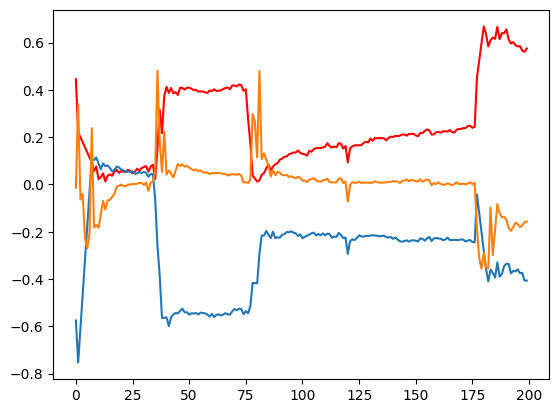

In [286]:
plt.plot(test_frame['R_EYE'],'r')
plt.plot(test_frame['L_EYE'])
plt.plot(test_frame['MCURVE_tail'])
# plt.ylim(-1,2)

- Sliding window of (0.5) sec
- if the first and last point of window vary by xyz amount then there was a vergence event
- record the event start and end 
- continue slider from last point of window


In [126]:
test_frame['R_EYE']

0      0.445059
1      0.221185
2      0.199885
3      0.178654
4      0.157422
         ...   
195    0.584182
196    0.585379
197    0.566254
198    0.561384
199    0.575219
Name: R_EYE, Length: 200, dtype: float64

In [146]:
indices = np.arange(0,200)

In [147]:
zipped = list(zip(indices,test_frame['R_EYE']))

In [278]:
scatter = []
for window in windowed(zipped, 6, step=5,fillvalue=(199,np.array(test_frame['R_EYE'])[-1])):
    if abs(window[-1][1]) - abs(window[0][1]) > 0.3:
        scatter.append((window[0][0],window[-1][0]))


In [279]:
scatter

[(35, 40), (175, 180)]

In [280]:
x = [x[0] for x in scatter]
y = [x[1] for x in scatter]

In [281]:
x = x+y

In [282]:
y = np.array(test_frame['R_EYE'])[x]

In [10]:
fish0 = list_of_fish_dicts[0]
fish1 = list_of_fish_dicts[1]
fish2 = list_of_fish_dicts[2]
fish5 = list_of_fish_dicts[5]
fish10 = list_of_fish_dicts[10]
fish20 = list_of_fish_dicts[20]
fish30 = list_of_fish_dicts[30]
fish40 = list_of_fish_dicts[40]
fish49 = list_of_fish_dicts[49]

[(12, 17)]
[(12, 17), (116, 121)]


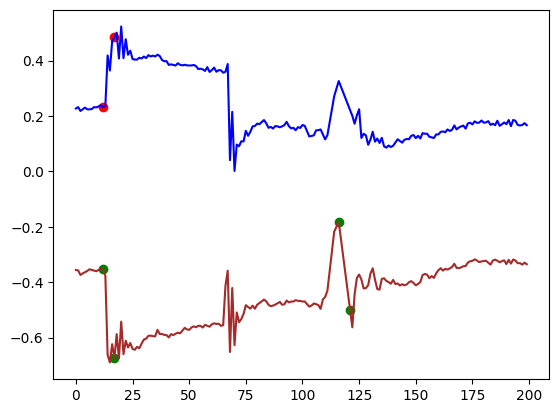

In [62]:
test_frame = fish49['STIM_type_5.SIZE_dot_0.004'][13]
indices = np.arange(0,200)
zipped_right = list(zip(indices,test_frame['R_EYE']))
scatter_right = []
for window in windowed(zipped_right, 6, step=5,fillvalue=(199,np.array(test_frame['R_EYE'])[-1])):
    if abs(window[-1][1]) - abs(window[0][1]) > 0.15:
        scatter_right.append((window[0][0],window[-1][0]))
start_right = [x[0] for x in scatter_right]
end_right = [x[1] for x in scatter_right]
x_right = start_right+end_right
y_right = np.array(test_frame['R_EYE'])[x_right]
print(scatter_right)
plt.plot(test_frame['R_EYE'],color='b')
plt.scatter(x_right,y_right,color='r')

zipped_left = list(zip(indices,test_frame['L_EYE']))
scatter_left = []
for window in windowed(zipped_left, 6, step=5,fillvalue=(199,np.array(test_frame['L_EYE'])[-1])):
    if abs(window[-1][1]) - abs(window[0][1]) > 0.15:
        scatter_left.append((window[0][0],window[-1][0]))
start_left = [x[0] for x in scatter_left]
end_left = [x[1] for x in scatter_left]
x_left = start_left+end_left
y_left = np.array(test_frame['L_EYE'])[x_left]
print(scatter_left)
plt.plot(test_frame['L_EYE'],color='brown')
plt.scatter(x_left,y_left,color='g');


# plt.xlim(180,196);

In [56]:
print(scatter_right)
print(scatter_left)

[(15, 20), (110, 115)]
[(10, 15), (115, 120)]


In [61]:
if len(scatter_right) == len(scatter_left):
    zipped_scatter = list(zip(scatter_right,scatter_left))
    for possible_event in zipped_scatter:
        print(possible_event)
        if possible_event[0][0] - possible_event[1][0] >= 5 or possible_event[1][0] - possible_event[0][0] >= 5:
            print("Nope")

    

((15, 20), (10, 15))
Nope
((110, 115), (115, 120))
Nope
